In [1]:
library("ggplot2") # графики
library("sandwich") # оценка Var для гетероскедастичности
library("lmtest") # тест Бройша-Пагана
library("dplyr") # манипуляции с данными

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Зафиксируем $\alpha = 0.05$ и посчитаем фактический уровень значимости для случая если остатки распределены как $Laplace$

In [2]:
library(distr)
library(extraDistr)

Loading required package: startupmsg
Utilities for Start-Up Messages (version 0.9.3)
For more information see ?"startupmsg", NEWS("startupmsg")

Loading required package: sfsmisc

Attaching package: ‘sfsmisc’

The following object is masked from ‘package:dplyr’:

    last

Loading required package: SweaveListingUtils
Utilities for Sweave Together with TeX 'listings' Package (version 0.7.5)
NOTE: Support for this package will stop soon.
Package 'knitr' is providing the same functionality in a better way.
Some functions from package 'base' are intentionally masked ---see SweaveListingMASK().
Note that global options are controlled by SweaveListingoptions() ---c.f. ?"SweaveListingoptions".
For more information see ?"SweaveListingUtils", NEWS("SweaveListingUtils")
There is a vignette to this package; try vignette("ExampleSweaveListingUtils").


Attaching package: ‘SweaveListingUtils’

The following objects are masked from ‘package:base’:

    library, require

Object Oriented Implementatio

In [57]:
alpha<-0.05
offset=10
sigma<-1
N<-40
T<-100
A<-100

In [58]:
res<-matrix(0,nrow = 2,ncol = N)
for(n in 1:N) {
    for(t in 1:T) {
        theta <- matrix(runif(n = n, min = 0,max = 1),ncol = 1)
        X <- matrix(runif(n = n * A, min = 0,max = 1),ncol = n)
        Y <- X %*% theta + matrix(rlaplace(n = A, m = 0, s = sigma), ncol=1)
        model <- lm(Y ~ X)
        pval <- gqtest(model, fraction = offset)$p.value
        res[1 + (pval > 0.05), n] <- res[1 + (pval > 0.05), n] + 1
    }
}

In [59]:
level = rep(0,N)
for(i in 1:N) {
    level[i] <- res[1,i]/T
}

In [60]:
level

[1] 0.15 0.12 0.14 0.16 0.09 0.11 0.12 0.13 0.16 0.14 0.11 0.10 0.10 0.09 0.13
[16] 0.14 0.12 0.08 0.11 0.12 0.07 0.13 0.08 0.06 0.08 0.12 0.05 0.13 0.07 0.09
[31] 0.04 0.10 0.07 0.11 0.09 0.07 0.06 0.07 0.09 0.04

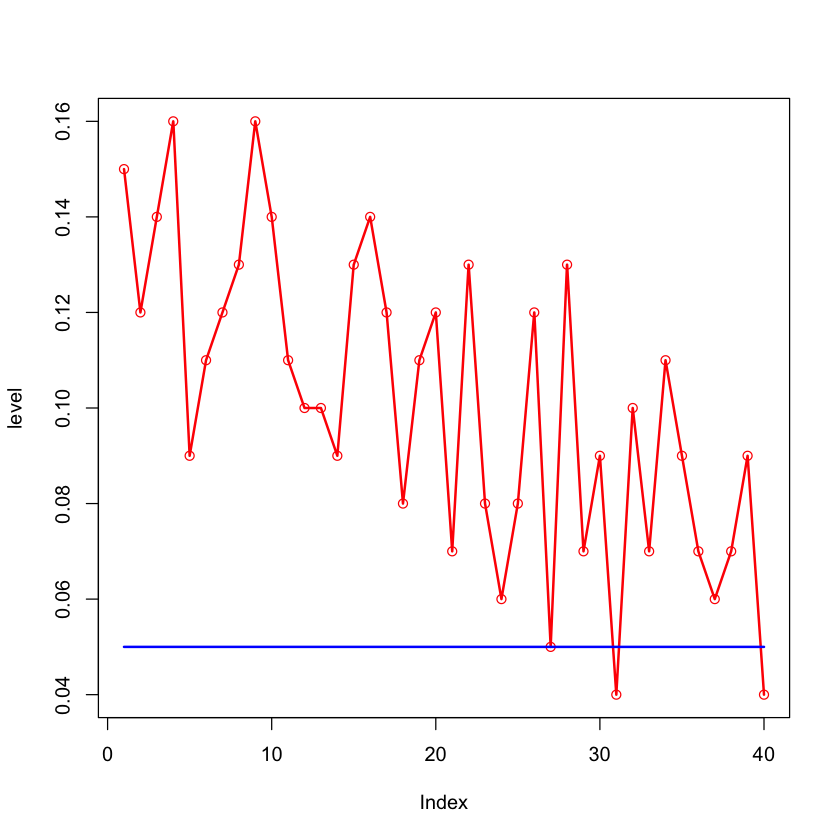

In [61]:
plot(level,col = 'red')
lines(level, col = "red", lwd = 2)
lines(rep(0.05,N), col = "blue", lwd = 2)

фактический уровень значимости оказывается выше 0.05 (возможно в пределе по N его достигает)

проверим тоже самое для модели в которой i ошибка распределена как $Laplace(\sigma^2(1 + i/n))$

In [63]:
res2<-matrix(0,nrow = 2,ncol = N)
for(n in 1:N) {
    for(t in 1:T) {
        theta <- matrix(runif(n = n, min = 0,max = 1),ncol = 1)
        X <- matrix(runif(n = n * A, min = 0,max = 1),ncol = n)
        eps <- rep(0, A)
        for(i in 1:n) {
            eps[i] <- rlaplace(n = 1, m = 0, s = (1 + i/n))
        }
        Y <- X %*% theta + matrix(eps,ncol = 1)
        model <- lm(Y ~ X)
        pval <- gqtest(model, fraction = offset)$p.value
        res2[1 + (pval > 0.05), n] <- res2[1 + (pval > 0.05), n] + 1
    }
}

In [64]:
res2

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
100,100,100,100,100,100,100,100,100,100,⋯,100,100,100,100,100,100,100,100,100,100


In [65]:
level2 = rep(0,N)
for(i in 1:N) {
    level2[i] <- res2[1,i]/T
}

In [66]:
level2

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0

получилось так, что критерий вообще ни разу не отверг в данном случае ничего
возможно, дело в том, что разница дисперсий не очень велика (все дисперсии - числа, выбранные равномерно от 1 до 2)